# Libraries

In [1]:
import joblib

import math

import matplotlib.pyplot as plt

import numpy as np

import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Constant

In [2]:
INPUT_DIR = os.path.join('..', 'data', 'processed')
MODEL_DIR = os.path.join('..', 'models')
SCALER_DIR = os.path.join('..', 'data', 'scalers')
MODEL_VERSION = 'v01'

# Config

In [3]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Import

In [4]:
class CombatForecastDataset(Dataset):
    def __init__(self, path_lb_our, path_lb_bandit, path_fc_action, path_fc_our, path_fc_bandit, sos_value=9999.0):
        self.lb_our = np.load(path_lb_our)          # (N, 10, 18)
        self.lb_bandit = np.load(path_lb_bandit)    # (N, 10, 13)
        self.fc_action = np.load(path_fc_action)    # (N, 3, 10)
        self.fc_our = np.load(path_fc_our)          # (N, 3, 18)
        self.fc_bandit = np.load(path_fc_bandit)    # (N, 3, 13)
        self.sos_value = sos_value
        self.nr_of_padding = self.lb_our.shape[-1] - self.lb_bandit.shape[-1]

    def __len__(self):
        return len(self.lb_our)

    def __getitem__(self, idx):
        lb_our = self.lb_our[idx]         # (10, 18)
        lb_bandit = self.lb_bandit[idx]   # (10, 13)
    
        # Pad lb_bandit to (10, 18)
        pad_width = ((0, 0), (0, self.nr_of_padding))  # pad 5 columns (features) at the end
        lb_bandit_padded = np.pad(lb_bandit, pad_width=pad_width, mode='constant', constant_values=0)
    
        # Now both are (10, 18) → stack along time axis (axis=0)
        src = np.concatenate([lb_our, lb_bandit_padded], axis=0)  # (20, 18)
    
        # Decoder input
        tgt = self.fc_action[idx]  # (3, 10)
        sos = np.ones((1, tgt.shape[1])) * self.sos_value
        tgt_input = np.vstack([sos, tgt[:-1]])  # (3, 10)

        # Target output
        tgt_output = np.concatenate([self.fc_our[idx], self.fc_bandit[idx]], axis=-1)  # (3, 31)
    
        return (
            torch.tensor(src, dtype=torch.float32),        # encoder input (20, 18)
            torch.tensor(tgt_input, dtype=torch.float32),  # decoder input (3, 10)
            torch.tensor(tgt_output, dtype=torch.float32)  # decoder target (3, 31)
        )

In [5]:
testing_dataset = CombatForecastDataset(
    os.path.join(INPUT_DIR, 'test_lb_state_our.npy'),
    os.path.join(INPUT_DIR, 'test_lb_state_bandit.npy'),
    os.path.join(INPUT_DIR, 'test_fc_action_our.npy'),
    os.path.join(INPUT_DIR, 'test_fc_state_our.npy'),
    os.path.join(INPUT_DIR, 'test_fc_state_bandit.npy'),
    sos_value=0)

In [6]:
scaler_cord_x = joblib.load(os.path.join(SCALER_DIR, 'cord_x.pkl'))
scaler_cord_y = joblib.load(os.path.join(SCALER_DIR, 'cord_y.pkl'))
scaler_cord_z = joblib.load(os.path.join(SCALER_DIR, 'cord_z.pkl'))

# Analysis

## UDF 

In [7]:
class ForecastTransformer(nn.Module):
    def __init__(self, enc_input_dim=18, dec_input_dim=10, out_dim=31,
                 d_model=256, nhead=4, num_encoder_layers=3, num_decoder_layers=3,
                 dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        # Project encoder and decoder inputs to d_model
        self.encoder_input_proj = nn.Linear(enc_input_dim, d_model)
        self.decoder_input_proj = nn.Linear(dec_input_dim, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )

        # Output projection to target dimension
        self.output_proj = nn.Linear(d_model, out_dim)

    def forward(self, src, tgt_input, tgt_mask=None):
        # src: (batch, src_seq_len, enc_input_dim)
        # tgt_input: (batch, tgt_seq_len, dec_input_dim)

        src = self.encoder_input_proj(src) * math.sqrt(self.d_model)  # (batch, 20, d_model)
        tgt = self.decoder_input_proj(tgt_input) * math.sqrt(self.d_model)  # (batch, 3, d_model)

        src = self.positional_encoding(src).transpose(0, 1)  # (20, batch, d_model)
        tgt = self.positional_encoding(tgt).transpose(0, 1)  # (3, batch, d_model)

        out = self.transformer(src, tgt, tgt_mask=tgt_mask)  # (3, batch, d_model)
        out = self.output_proj(out.transpose(0, 1))  # (batch, 3, out_dim)

        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)  # correctly handled across devices

    def forward(self, x):
        # Automatically move self.pe to same device as x
        return x + self.pe[:, :x.size(1)].to(x.device)

## Compile

In [8]:
test_data_loader = DataLoader(testing_dataset, batch_size=128, shuffle=True)
model = ForecastTransformer(
    enc_input_dim=15,
    dec_input_dim=9,
    out_dim=6,
    d_model=256,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=512,
    dropout=0.1)\
    .to(device)

model.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'{MODEL_VERSION}.pth')))

model.eval()

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ForecastTransformer(
  (encoder_input_proj): Linear(in_features=15, out_features=256, bias=True)
  (decoder_input_proj): Linear(in_features=9, out_features=256, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNo

## Predict

In [9]:
# Prevent model from seeing future tokens during training
def generate_square_subsequent_mask(sz):
    return torch.triu(torch.ones((sz, sz)) * float('-inf'), diagonal=1)

all_predictions = []
all_truth = []
# Loop through the test data loader to perform inference on each batch
with torch.no_grad():  # Disable gradient computation during inference
    for src, tgt_input, tgt_output in test_data_loader:
        src, tgt_input, tgt_output = src.to(device), tgt_input.to(device), tgt_output.to(device)
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
        # Perform inference
        outputs = model(src, tgt_input, tgt_mask)
        
        # Store the outputs (predictions) for each batch
        all_predictions.append(outputs.cpu())  # Move to CPU if using GPU
        all_truth.append(tgt_output.cpu())

# Convert the predictions to a single tensor
all_predictions = torch.cat(all_predictions, dim=0)
all_truth = torch.cat(all_truth, dim=0)

## Analyze

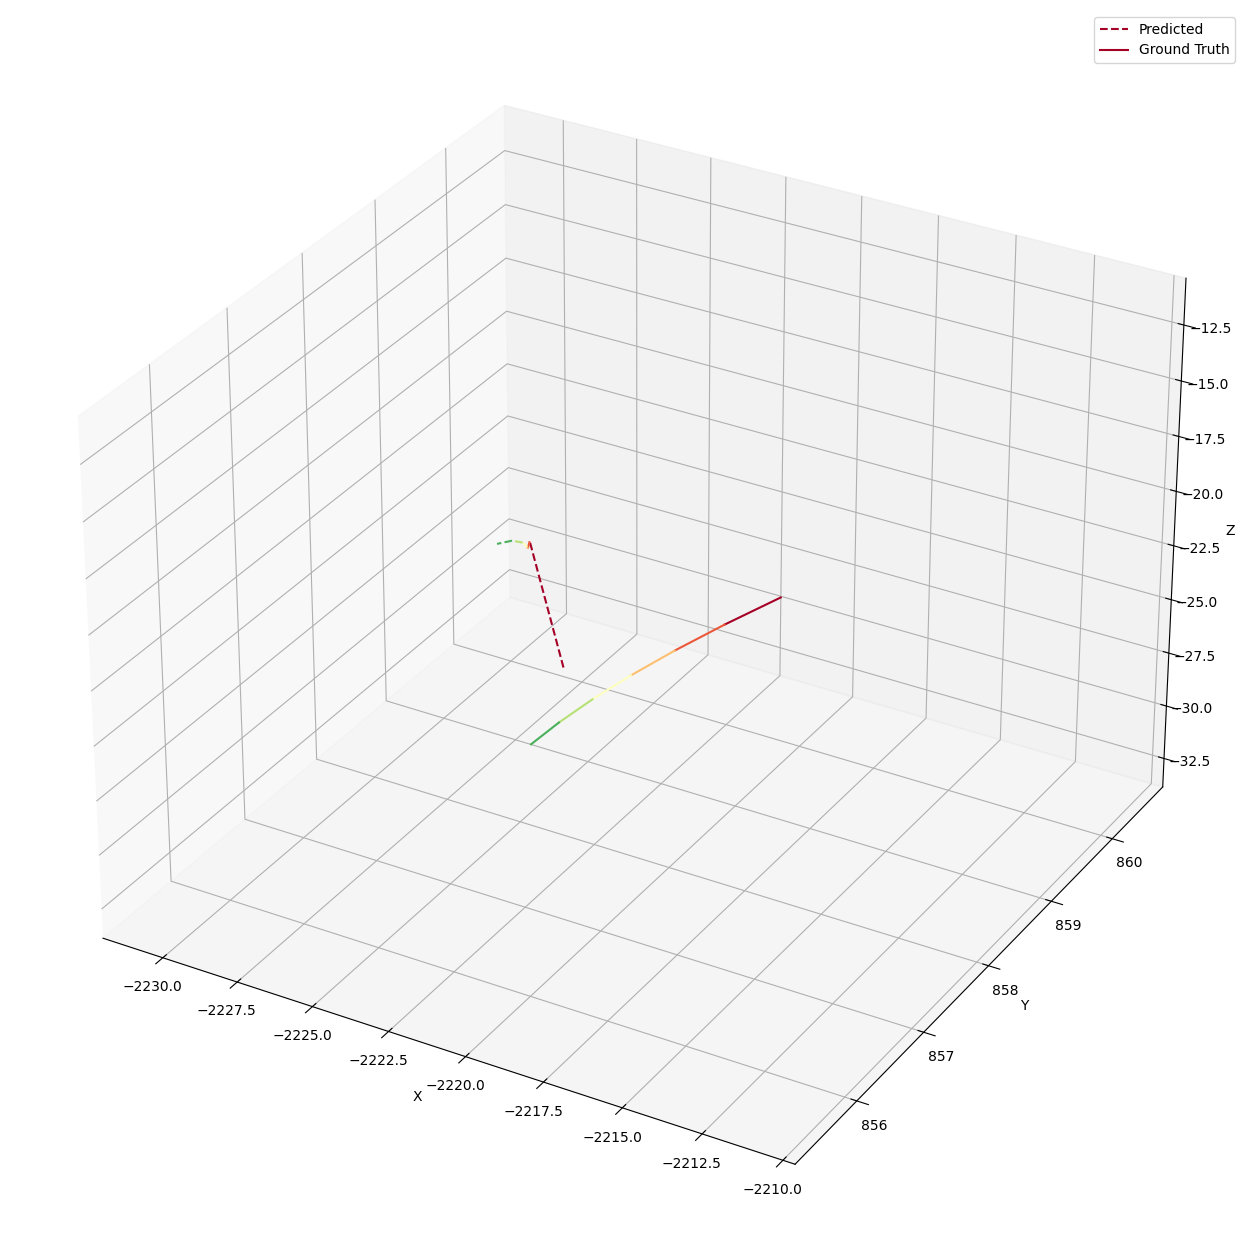

In [10]:
sample_id = 10
pred = all_predictions[sample_id]
truth = all_truth[sample_id]

# Extracting x, y, and z coordinates for both predicted and ground truth
x_pred = scaler_cord_x.inverse_transform(pred[:, [3]]).squeeze()
y_pred = scaler_cord_y.inverse_transform(pred[:, [4]]).squeeze()
z_pred = scaler_cord_z.inverse_transform(pred[:, [5]]).squeeze()

x_gt = scaler_cord_x.inverse_transform(truth[:, [3]]).squeeze()
y_gt = scaler_cord_y.inverse_transform(truth[:, [4]]).squeeze()
z_gt = scaler_cord_z.inverse_transform(truth[:, [5]]).squeeze()

# Create a figure and a 3D axis
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

# Create a colormap, normalize the timesteps to the range [0, 1]
cmap = plt.get_cmap('RdYlGn')  # Red to Green colormap (Green is earlier, Red is later)
norm = plt.Normalize(vmin=0, vmax=len(x_pred) - 1)

# Plotting the predicted trajectory with color based on the timestep
for i in range(len(x_pred) - 1):
    ax.plot([x_pred[i], x_pred[i+1]], [y_pred[i], y_pred[i+1]], [z_pred[i], z_pred[i+1]], color=cmap(norm(i)), linestyle='--', label='Predicted' if i == 0 else "")

# Plotting the ground truth trajectory with dashed lines and same colors as predicted
for i in range(len(x_gt) - 1):
    ax.plot([x_gt[i], x_gt[i+1]], [y_gt[i], y_gt[i+1]], [z_gt[i], z_gt[i+1]], color=cmap(norm(i)), label='Ground Truth' if i == 0 else "")

# Labeling axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add legend
ax.legend()

# Show the plot
plt.show()